In [1]:
import numpy as np
import pandas as pd
import dynamo as dyn
import scipy.sparse as sp
from random import uniform
from scipy.stats import ttest_ind
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

/opt/anaconda3/envs/graphvelo-release/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from graphvelo.graph_velocity import tangent_space_projection
from graphvelo.tangent_space import corr_kernel, cos_corr, density_corrected_transition_matrix

In [3]:
tau=1
simulator = dyn.sim.BifurcationTwoGenes(dyn.sim.bifur2genes_params, tau=tau)

|-----> The model contains 2 genes and 2 species
|-----> Adjusting parameters based on `r_aug` and `tau`...
|-----> 10 initial conditions have been created by augmentation.


In [4]:
simulator.simulate([0, 40], n_cells=2000)
adata = simulator.generate_anndata()
adata.obsm['X_raw'] = adata.layers['total'].copy()
adata.obsm['velocity_raw'] = adata.layers['velocity_T'].copy()

|-----> Sampling 2000 from 35794 simulated data points.
|-----> 2000 cell with 2 genes stored in AnnData.


/opt/anaconda3/envs/graphvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


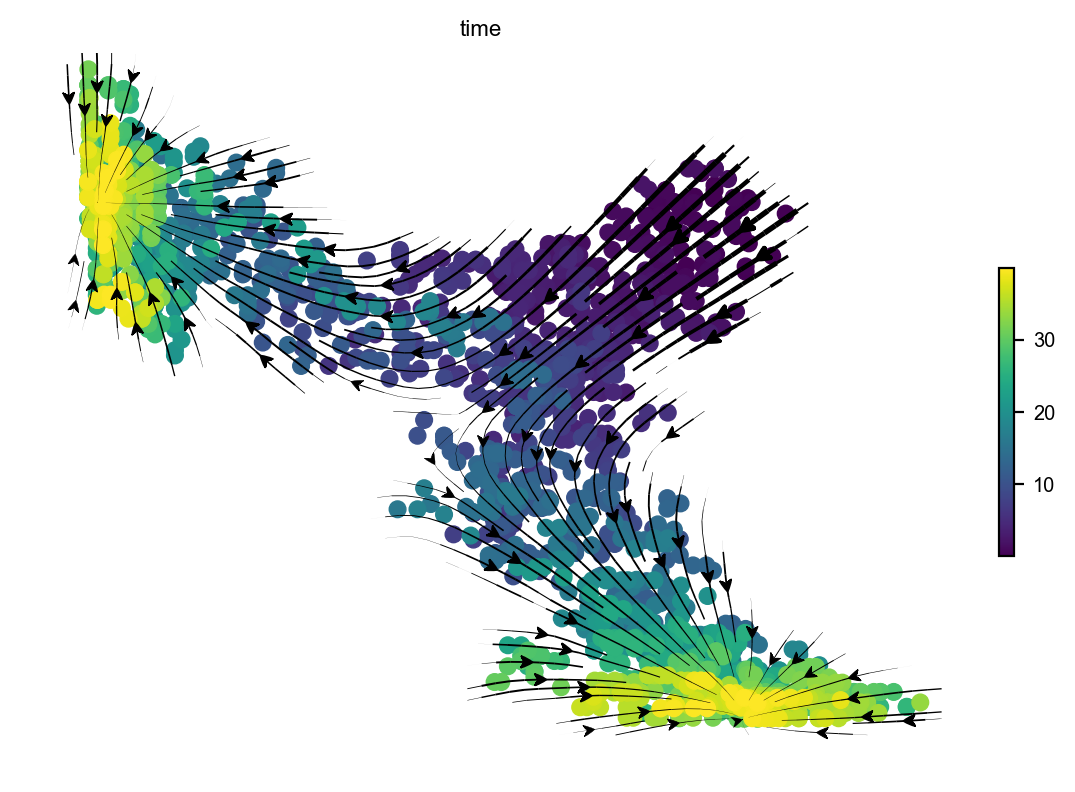

In [5]:
ax = dyn.pl.zscatter(adata, basis='raw', color='time', cmap='viridis', save_show_or_return='return')
dyn.pl.zstreamline(adata, basis='raw')

In [6]:
# adata.write('bif_sim.h5ad')

In [7]:
adata = dyn.read('bif_sim.h5ad')
adata

AnnData object with n_obs × n_vars = 2000 × 2
    obs: 'trajectory', 'time'
    var: 'a', 'b', 'S', 'K', 'm', 'n', 'gamma'
    obsm: 'X_raw', 'velocity_raw'
    layers: 'total', 'velocity_T'

## Mapping 2d vector field to 3d

In [8]:
def mapping(X, center_x, center_y, radius):
    x_2d = X[:, 0]
    y_2d = X[:, 1]  
    x_3d = x_2d
    y_3d = y_2d
    z_3d = np.sqrt(np.maximum(0, radius**2 - (x_2d - center_x)**2 - (y_2d - center_y)**2))
    XYZ_3d = np.column_stack((x_3d, y_3d, z_3d))
    return XYZ_3d

def mapping_with_velocity(X_t0, X_t1, dt, center_x, center_y, radius):
    ### (Y-X)/delta_t
    XYZ_3d = mapping(X_t0, center_x, center_y, radius)
    XYZ_3d_ = mapping(X_t1, center_x, center_y, radius)
    
    return (XYZ_3d_ - XYZ_3d) / dt

def add_noise(X_3d, V_tangent, epsilon_range=(0, 1), center_x=60, center_y=60):
    center = np.array([center_x, center_y, 0])
    noisy_V_tangent = np.zeros_like(V_tangent)

    for i in range(X_3d.shape[0]):
        point = X_3d[i]
        normal_vector = point - center
        normal_vector /= np.linalg.norm(normal_vector)

        tangent_magnitude = np.linalg.norm(V_tangent[i])
        
        epsilon = uniform(*epsilon_range)
        noise_vector = epsilon * tangent_magnitude * normal_vector
        
        noisy_V_tangent[i] = V_tangent[i] + noise_vector
    
    return noisy_V_tangent

In [9]:
center_x, center_y = 60, 60
r  = 70
dt = 1
X = adata.layers['total']
V = adata.layers['velocity_T']
X_3d = mapping(X, center_x, center_y, radius=r)
V_tangent = mapping_with_velocity(X, X+V*dt, dt, center_x, center_y, r)
V_noisy = add_noise(X_3d, V_tangent, epsilon_range=(0, 1), center_x=center_x, center_y=center_y)

In [10]:
normals = X_3d - np.array([center_x, center_y, 0])
V_N = np.zeros_like(V_tangent)
V_N_noise = np.zeros_like(V_tangent)
for i in range(V_N.shape[0]):  
    V_N[i] = (np.dot(V_tangent[i], normals[i]) / np.dot(normals[i], normals[i])) * normals[i]
    V_N_noise[i] = (np.dot(V_noisy[i], normals[i]) / np.dot(normals[i], normals[i])) * normals[i]

In [11]:
def project_velocity(X_embedding, T=None) -> np.ndarray:
    n = T.shape[0]
    delta_X = np.zeros((n, X_embedding.shape[1]))
    for i in range(n):
        idx = T[i].indices
        diff_emb = X_embedding[idx] - X_embedding[i, None]
        if np.isnan(diff_emb).sum() != 0:
            diff_emb[np.isnan(diff_emb)] = 0
        T_i = T[i].data
        delta_X[i] = T_i.dot(diff_emb)

    return delta_X

In [12]:
nbrs = NearestNeighbors(n_neighbors=15).fit(X_3d)
dist, ind = nbrs.kneighbors(X_3d)

In [13]:
# GraphVelo implementation
P = corr_kernel(X_3d, V_noisy, ind, corr_func=cos_corr)
P_dc = density_corrected_transition_matrix(P).A
T = tangent_space_projection(X_3d, V_noisy, P_dc, ind, b=0)
T = sp.csr_matrix(T)
V_p = project_velocity(X_3d, T)
V_cos = project_velocity(X_3d, sp.csr_matrix(P_dc))

Learning Phi in tangent space projection.: 100%|██████████| 2000/2000 [00:02<00:00, 989.53it/s] 


In [14]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, max_y = None, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 0.8)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.005)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom if max_y is None else max_y - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )
    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [15]:
palette = {"GraphVelo": "#f15a24", "cosine kernel": "#ab99e7"}

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_96564/1376135066.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Velocity', y='Normal components', palette=palette, ax=ax,)


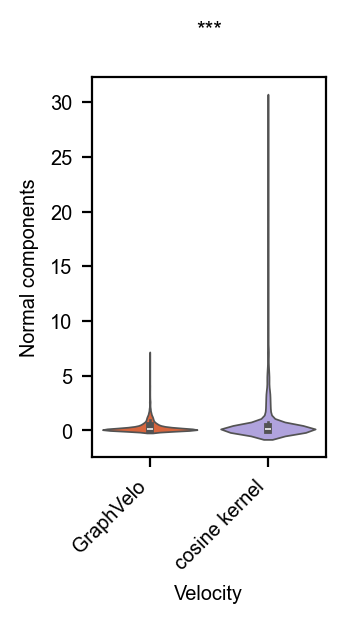

In [16]:
V_Np = np.zeros_like(V_p)
V_Ncos = np.zeros_like(V_p)
for i in range(V_Np.shape[0]):  
    V_Np[i] = (np.dot(V_p[i], normals[i]) / np.dot(normals[i], normals[i])) * normals[i]
    V_Ncos[i] = (np.dot(V_cos[i], normals[i]) / np.dot(normals[i], normals[i])) * normals[i]
df = pd.DataFrame({
    'Normal components': list(np.linalg.norm(V_Np, axis=1)) + list(np.linalg.norm(V_Ncos, axis=1)), 
    'Velocity': ['GraphVelo']*V_p.shape[0] + ['cosine kernel']*V_p.shape[0]
    })
fig, ax = plt.subplots(figsize=(1.5, 2.5))
sns.violinplot(df, x='Velocity', y='Normal components', palette=palette, ax=ax,)
plt.xticks(rotation = 45, ha='right')
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max + 0.02])
# plt.ylim(0, 0.5)
ttest_res = ttest_ind(np.linalg.norm(V_Np, axis=1), np.linalg.norm(V_Ncos, axis=1), equal_var=False, alternative="less")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.1, c="k", level=0
)
# plt.savefig(dpi=300, transparent=True, fname=f'figures/normal_components.pdf', bbox_inches = "tight")
plt.show()

In [17]:
sim = np.diag(cosine_similarity(V_p, V_tangent))
sim_cos = np.diag(cosine_similarity(V_cos, V_tangent))
rmse = np.array([np.linalg.norm(V_p[i] - V_tangent[i])/np.sqrt(len(V_p[i])) for i in range(V_p.shape[0])])
rmse_cos = np.array([np.linalg.norm(V_cos[i] - V_tangent[i])/np.sqrt(len(V_p[i])) for i in range(V_p.shape[0])])

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_96564/1978391663.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Model", y="cosine similarity", palette="colorblind", ax=ax)


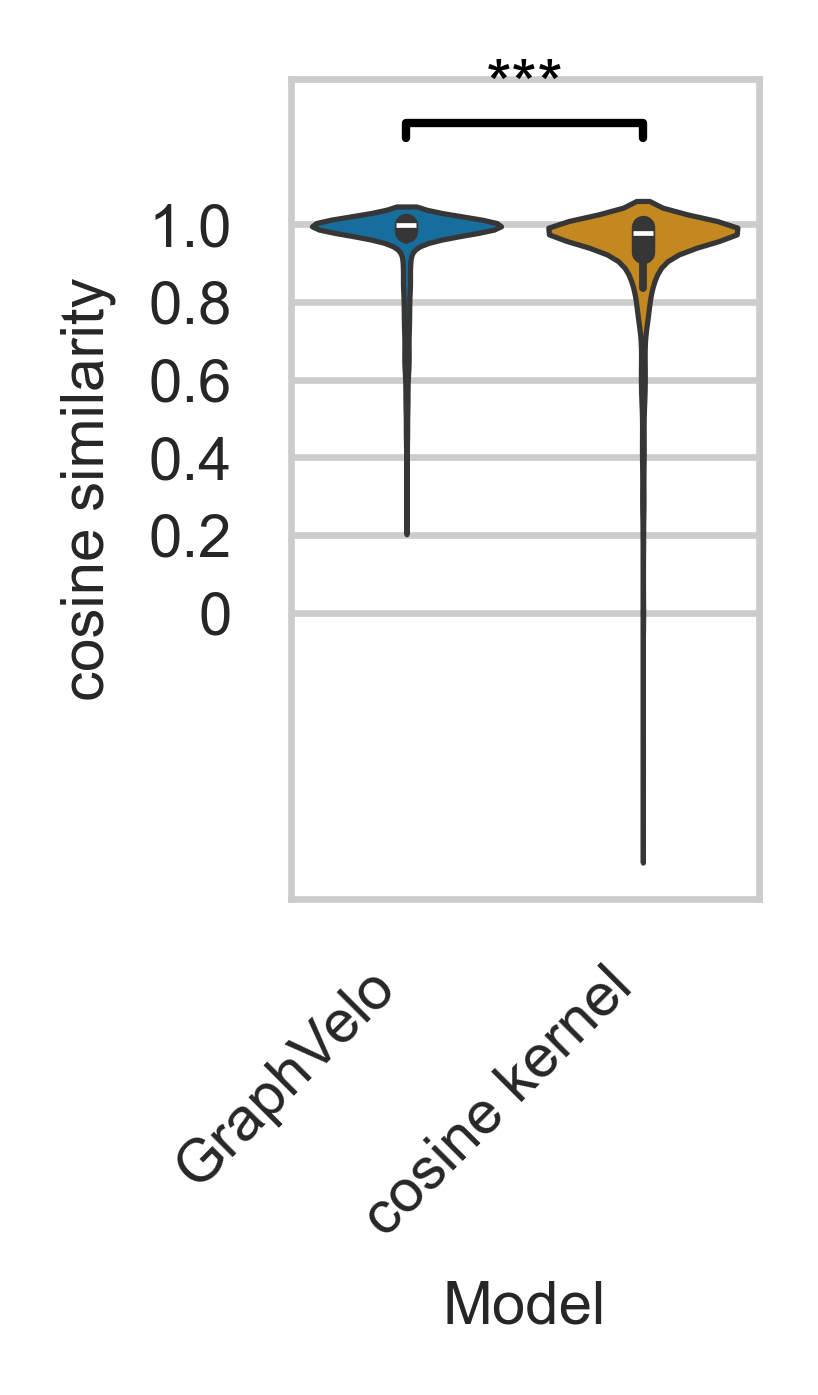

In [18]:
df = pd.DataFrame(
    {
        "cosine similarity": sim.tolist()+sim_cos.tolist(),
        "Model": ["GraphVelo"] * len(sim) + ["cosine kernel"] * len(sim_cos)
    }
)
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(1, 1.8), dpi=300)

sns.violinplot(data=df, x="Model", y="cosine similarity", palette="colorblind", ax=ax)

ttest_res = ttest_ind(sim, sim_cos, equal_var=False, alternative="greater")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.1, c="k", level=0
)

y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max + 0.02])

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/cosine_sim.pdf', bbox_inches = "tight")
plt.show()

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_96564/2143150486.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_rmse, x="Model", y="RMSE", palette="colorblind", ax=ax)


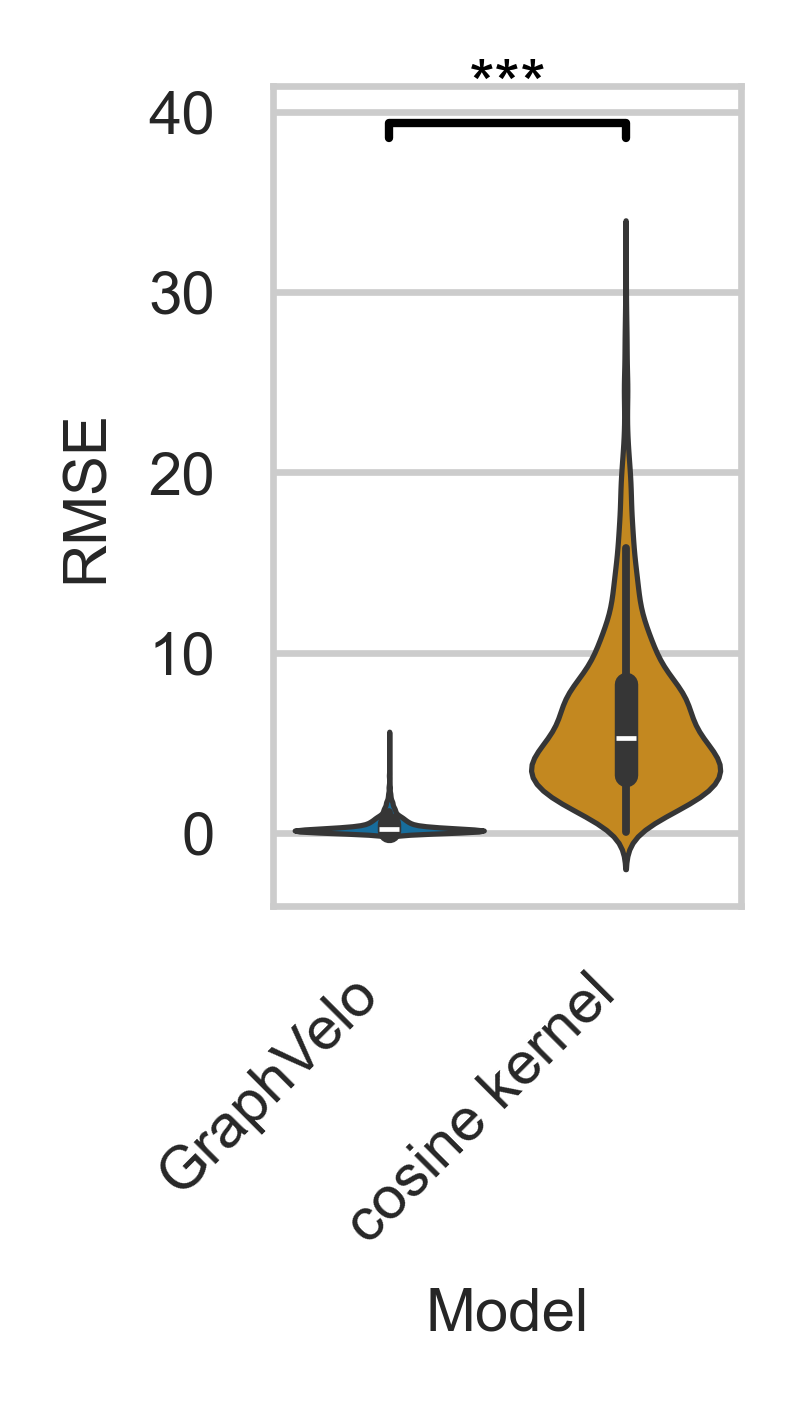

In [19]:
df_rmse = pd.DataFrame(
    {
        "RMSE": rmse.tolist()+rmse_cos.tolist(),
        "Model": ["GraphVelo"] * len(rmse) + ["cosine kernel"] * len(rmse_cos)
    }
)
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(1, 1.8), dpi=300)

sns.violinplot(data=df_rmse, x="Model", y="RMSE", palette="colorblind", ax=ax)

ttest_res = ttest_ind(rmse, rmse_cos, equal_var=False, alternative="less")
significance = get_significance(ttest_res.pvalue)
add_significance(
    ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.1, c="k", level=0
)

y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max + 0.02])

plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/rmse.pdf', bbox_inches = "tight")
plt.show()

In [20]:
def plot_3d_vector_field(X, V, c, radius, downsample, scale=0.1, norm_v=True, size=5, line_width=4, cone_size=1, add_surface=True, surface_alpha=0.6, camera_view=[1, 1, 1]):
    import matplotlib
    import matplotlib.colors as mcolors

    norm = mcolors.Normalize(vmin=np.min(c), vmax=np.max(c))
    viridis = matplotlib.colormaps['plasma']
    colors = viridis(norm(c))
    colors_hex = [mcolors.to_hex(c) for c in colors]

    if norm_v:
        from sklearn.preprocessing import normalize
        V = normalize(V, axis=0, norm="l2")
        V = normalize(V, axis=1, norm="l2")
    V = scale * V 
    fig = go.Figure()

    # Surface
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = np.sqrt(radius**2 - (x_grid - center_x)**2 - (y_grid - center_y)**2)
    
    if add_surface:
        fig.add_surface(x=x_grid, y=y_grid, z=z_grid, colorscale=[[0, '#99BADF'], [1, '#99BADF']], showscale=False, opacity=surface_alpha)

    fig.add_trace(go.Scatter3d(
        x=X[:, 0], y=X[:, 1], z=X[:, 2],
        mode='markers',
        marker=dict(size=size, color=colors_hex, opacity=0.5),
    ))
    end_points = X + V
    X_downsample = X[::downsample]
    end_points_downsample = end_points[::downsample]
    
    for i in range(len(X_downsample)):
        fig.add_trace(go.Scatter3d(
            x=[X_downsample[i, 0], end_points_downsample[i, 0]],
            y=[X_downsample[i, 1], end_points_downsample[i, 1]],
            z=[X_downsample[i, 2], end_points_downsample[i, 2]],
            mode='lines',
            line=dict(color='black', width=line_width),
            showlegend=False
        ))

    fig.add_trace(go.Cone(
        x=end_points_downsample[:, 0],
        y=end_points_downsample[:, 1],
        z=end_points_downsample[:, 2],
        u=V[::downsample, 0],
        v=V[::downsample, 1],
        w=V[::downsample, 2],
        colorscale=[[0, 'black'], [1, 'black']],
        sizeref=cone_size,
        # opacity=1.0,
        showscale=False
    ))

    eye = dict(x=camera_view[0], y=camera_view[1], z=camera_view[2])

    fig.update_layout(
        showlegend=False,
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,
            ),
            yaxis=dict(
                title='',
                showticklabels=False,
            ),
            zaxis=dict(
                title='',
                showticklabels=False,
            ),
            aspectratio=dict(
                x=1,
                y=1,
                z=0.5,),
            camera=dict(
                eye=eye)
            )
    )
    return fig

In [21]:
fig = plot_3d_vector_field(X_3d, V_noisy, adata.obs['time'].values, radius=r, size=5, scale=5, downsample=2, line_width=5, cone_size=3, camera_view=(0.2, 0.5, 0.5)) # (0.3, 0.8, 0.6)
fig.show()

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_96564/1669440842.py:23: RuntimeWarning:

invalid value encountered in sqrt



In [28]:
fig = plot_3d_vector_field(X_3d, V_p, adata.obs['time'].values, radius=r, size=5, scale=5, downsample=2, line_width=5, cone_size=5, camera_view=(0.2, 0.5, 0.5))
fig.show()

/var/folders/zr/17m1_r_x57q5mxr1zs8px9rh0000gn/T/ipykernel_96564/1669440842.py:23: RuntimeWarning:

invalid value encountered in sqrt

